# A. Visualisation et Prétraitement des données 



In [70]:
pip install pandas matplotlib

4413.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"

data = pd.read_csv(file_path)


In [19]:

import pandas as pd
# Renommer les colonnes en tenant compte de leur nombre
data.columns = ['Temps', 'X', 'Y', 'Z']  # Ajoutez un nom pour chaque colonne présente

# Convertir la colonne 'Temps' en datetime si ce n'est pas déjà fait
data['Temps'] = pd.to_datetime(data['Temps'])

# Calculer le temps écoulé en secondes entre chaque ligne
data['Temps écoulé (s)'] = data['Temps'].diff().dt.total_seconds().fillna(0)

# Créer une nouvelle colonne pour le temps cumulé croissant
data['Temps cumulé (s)'] = data['Temps écoulé (s)'].cumsum()

# Afficher les premières lignes pour vérifier
data.head()



,Temps,X,Y,Z,Temps écoulé (s),Temps cumulé (s)
0,2024-10-06 15:39:03.100,0.234375,-0.703125,0.093750,0.000,0.000
1,2024-10-06 15:39:03.102,0.281250,-0.765625,0.093750,0.002,0.002
2,2024-10-06 15:39:03.105,0.281250,-0.765625,0.109375,0.003,0.005
3,2024-10-06 15:39:03.107,0.234375,-0.781250,0.109375,0.002,0.007
4,2024-10-06 15:39:03.110,0.234375,-0.781250,0.093750,0.003,0.010


## Données Brutes au cours du temps (s)

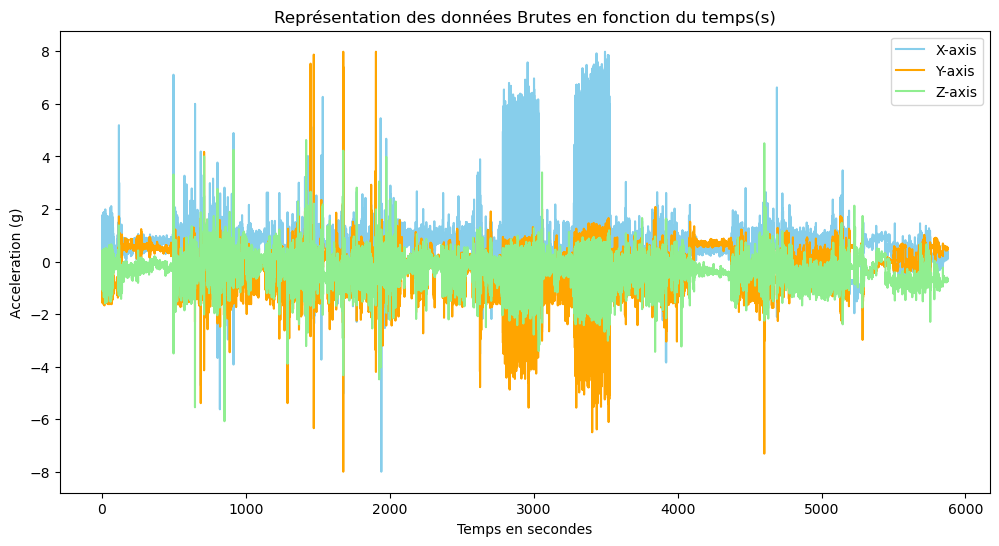

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"
data = pd.read_csv(file_path)

# Vérifiez les colonnes et assurez-vous qu'elles ont les noms attendus
timestamp_column = data.columns[0]
signal_columns = data.columns[1:4]  # Sélectionner uniquement les colonnes 1, 2 et 3 pour le signal (X, Y, Z)

# Convertir la colonne de timestamps en datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')

# Supprimer les lignes avec des timestamps non valides
data = data.dropna(subset=[timestamp_column])

# Renommer les colonnes pour une meilleure clarté
data.columns = ['Temps', 'X', 'Y', 'Z']

# Convertir la colonne 'Temps' en datetime
data['Temps'] = pd.to_datetime(data['Temps'])

# Vérifiez s'il reste au moins deux lignes pour calculer l'intervalle
if len(data) > 1:
    # Calculer l'intervalle d'échantillonnage en secondes
    sampling_interval = (
        data['Temps'].iloc[1] - data['Temps'].iloc[0]
    ).total_seconds()
else:
    raise ValueError("Le fichier contient moins de deux entrées valides pour calculer l'intervalle d'échantillonnage.")

# Créer une colonne pour le temps relatif en secondes
data['relative_time_seconds'] = data.index * sampling_interval

# Définir les étiquettes des axes et les couleurs
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'Skyblue', 'Y': 'orange', 'Z': 'lightgreen'}

# Tracer le signal
plt.figure(figsize=(12, 6))
for signal, axis_label, color in zip(['X', 'Y', 'Z'], axis_labels, colors.values()):  # Utiliser uniquement X, Y, Z
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label, color=color)

plt.title("Représentation des données Brutes en fonction du temps(s)")
plt.xlabel("Temps en secondes")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()


## Prétraitement des données : Application d'un filtre passe bas :

In [74]:
# Recalculer les métriques des axes (X, Y, Z) sans dépendre de SciPy
import pandas as pd

def calculate_basic_metrics(signal):
    # Nombre de pics détectés manuellement : simple dérivée pour détection de variations significatives
    peaks = (signal[1:-1] > signal[:-2]) & (signal[1:-1] > signal[2:])
    num_peaks = peaks.sum()
    
    # Intensité moyenne (amplitude)
    mean_amplitude = signal.max() - signal.min() if len(signal) > 0 else 0
    
    return num_peaks, mean_amplitude

# Calcul des métriques pour chaque axe
metrics = {}
for axis in ['X', 'Y', 'Z']:
    signal = data[axis].values
    num_peaks, mean_amplitude = calculate_basic_metrics(signal)
    metrics[axis] = {
        'Nombre de pics': num_peaks,
        'Amplitude moyenne': mean_amplitude,
    }

# Calculer la corrélation entre les axes X, Y et Z
correlations = data[['X', 'Y', 'Z']].corr()

# Présenter les résultats des métriques et des corrélations
metrics_df = pd.DataFrame(metrics).T
print("Métriques des Axes (X, Y, Z):\n", metrics_df)
print("\nCorrélations entre les Axes (X, Y, Z):\n", correlations)


Métriques des Axes (X, Y, Z):
    Nombre de pics  Amplitude moyenne
X        150385.0          15.984375
Y        164599.0          15.984375
Z        202530.0          10.703125

Corrélations entre les Axes (X, Y, Z):
           X         Y         Z
X  1.000000 -0.257405 -0.165001
Y -0.257405  1.000000 -0.136309
Z -0.165001 -0.136309  1.000000


L'axe Z présente plus de pics que l'axe X et Y, quasiment 1/4 de pics supplémentaires, ce qui indique que l'activité mesurée présente plus de variations rapides sur l'axe Z, comme une oscillation ou une activité périodique. 
Cependant l'amplitude moyenne est plus faible sur l'axe Z. Les variations sur l'axe Z sont donc plus fréquentes mais de moins grosse intensité. 

En course, ces pics représentent les oscillations du corps dans différentes directions :

  - X :  Mouvement latéral (oscillations gauche-droite des bras ou des hanches).
  - Y : Mouvement vers l'avant ou l'arrière (propulsion ou oscillations en raison du pas de course).
- Z : Reflète les variations verticales (montées et descentes dues aux foulées).
Le fait que Z ait le plus grand nombre de pics montre que le mouvement vertical (les rebonds des foulées) est le plus rapide et le plus fréquent.


Les amplitudes similaires pour X et Y suggèrent que les mouvements latéraux (bras) et avant-arrière (propulsion) sont d'une intensité comparable.
L'amplitude plus faible sur Z est logique, car les oscillations verticales lors de la course sont généralement contrôlées (les rebonds sont amortis pour économiser de l'énergie et rester efficace).

L'axe Z montre une très faible corrélation négative avec X et Y, relevant des variations sur Z indépente de la variation de X et Y, d'ou le nombre de pics élévés sur Z. 
La corrélation entre X et Y reste modérément négative (-0.257), suggérant une légère opposition dans les variations entre ces deux axes.

#### *Corrélation faible entre Z et les autres axes :*
Cela montre que les variations verticales (Z) sont relativement indépendantes des mouvements latéraux (X) et avant-arrière (Y). Pendant la course, cela est attendu, car les rebonds (Z) suivent un rythme constant lié aux foulées, tandis que les bras et la propulsion peuvent varier.


La course implique un mouvement rythmique vertical dominant, comme le montrent le nombre élevé de pics et la cadence de l'axe Z. Cela reflète les cycles réguliers des foulées.

In [75]:
# Segmenter les données selon les périodes : échauffement, course intense, récupération
# Pour cette segmentation, il est courant d'utiliser le temps cumulé ou des règles basées sur des seuils (par exemple, amplitude, fréquence, etc.)
# Ici, supposons une segmentation temporelle simplifiée en divisant le temps total en trois parties égales.

# Définir les bornes temporelles pour la segmentation
total_time = data['Temps cumulé (s)'].iloc[-1]  # Temps total en secondes
split_1 = total_time / 3  # Fin de l'échauffement
split_2 = 2 * total_time / 3  # Fin de la course intense

# Ajouter une colonne pour la segmentation
def label_segment(time):
    if time <= split_1:
        return 'Échauffement'
    elif time <= split_2:
        return 'Course intense'
    else:
        return 'Récupération'

data['Période'] = data['Temps cumulé (s)'].apply(label_segment)

# Afficher les premières lignes pour vérifier la segmentation
data.head()

# Résumer les données par segment sans ace_tools
segment_summary = data.groupby('Période').agg({
    'X': ['mean', 'std'],
    'Y': ['mean', 'std'],
    'Z': ['mean', 'std']
})

# Afficher le résumé des segments
print("Résumé des données par période (Échauffement, Course intense, Récupération):")
print(segment_summary)

Résumé des données par période (Échauffement, Course intense, Récupération):
                       X                   Y                   Z          
                    mean       std      mean       std      mean       std
Période                                                                   
Course intense  0.613112  1.033022 -0.472375  0.710423 -0.245494  0.367189
Récupération    0.385386  0.421622 -0.031982  0.558585 -0.413029  0.347402
Échauffement    0.501815  0.323358 -0.228095  0.641804 -0.218783  0.348806




Pour chaque période et pour chaque axe (**X**, **Y**, **Z**), les statistiques suivantes sont calculées :
- **Mean (moyenne)** : Représente la valeur moyenne des signaux dans la période.
- **Std (écart-type)** : Représente la variation ou la dispersion des signaux dans la période, une mesure de l'intensité des variations.

---

### **Analyse par période :**

#### **1. Échauffement :**
- **Moyenne (X, Y, Z)** : Les valeurs moyennes sont plus faibles (autour de 0.5 pour X, -0.22 pour Y, et -0.21 pour Z), ce qui reflète des mouvements légers et contrôlés pendant l'échauffement.
- **Écart-type (X, Y, Z)** : Les variations sont modérées (écarts-types autour de 0.3 à 0.6), indiquant une intensité stable avec des mouvements réguliers mais moins dynamiques que pendant la course intense.

#### **2. Course intense :**
- **Moyenne (X, Y, Z)** :
  - La moyenne de X (**0.61**) est plus élevée, suggérant un mouvement latéral plus prononcé (balancement des bras).
  - La moyenne de Y (**-0.47**) montre une poussée constante dans le sens avant-arrière, typique d'une propulsion lors de la course.
  - La moyenne de Z (**-0.24**) indique une composante verticale modérée mais présente.
- **Écart-type (X, Y, Z)** :
  - L'écart-type de X (**1.03**) est le plus élevé, montrant de grandes variations latérales.
  - L'écart-type de Y (**0.71**) est également élevé, indiquant des variations fortes dues à la propulsion.
  - L'écart-Type de Z(**0.36**) est  modéré (pas trop élevé), ce qui indique que les mouvements verticaux sont réguliers et bien contrôlés.

#### **3. Récupération :**

- **Moyenne (X, Y, Z) :**
Les valeurs moyennes des axes X, Y et Z diminuent comparées à la course intense :
   - X : 0.385 : Les mouvements latéraux (balancement des bras) sont significativement réduits.
   - Y : -0.032 : La propulsion avant-arrière est presque inexistante, ce qui est cohérent avec une phase de récupération plus calme.
   - Z : -0.413 : Une légère composante verticale persiste, indiquant des mouvements plus doux (comme une marche ou des oscillations résiduelles).
- **Écart-type (X, Y, Z) :**
Les variations sont moindres sur tous les axes par rapport à la course intense, ce qui traduit une activité plus régulière et contrôlée :
   - X : 0.421 : Réduction des oscillations latérales.
   - Y : 0.559 : Des variations modérées persistent, probablement en lien avec des ajustements posturaux durant la récupération.
   - Z : 0.347 : Une amplitude faible et constante dans l’axe vertical, typique d’une marche ou d’un retour au repos.

#### *Analyse Globale : **
- **Échauffement :**
Activité modérée avec des variations stables et contrôlées.
Les signaux montrent une faible amplitude sur tous les axes, ce qui est cohérent avec une préparation progressive.
- **Course intense :**
L’activité devient beaucoup plus dynamique, avec des pics élevés sur tous les axes (notamment X et Y, correspondant aux mouvements des bras et à la propulsion).
Les variations sur l’axe Z (mouvement vertical) sont moins intenses mais régulières, reflétant une foulée bien rythmée et efficace.
- **Récupération :**
Une nette réduction des moyennes et des variations sur tous les axes, indiquant une transition vers un état plus calme (comme une marche ou un retour progressif au repos).


# B. Phase 2 : Analyse comparative 

In [76]:
# Calculate the sampling interval (in seconds)
sampling_interval = (pd.to_datetime(data[timestamp_column].iloc[1]) -
                     pd.to_datetime(data[timestamp_column].iloc[0])).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval / 60

# Plot the signal with time in minutes
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(data['relative_time_minutes'], data[signal], label=signal)

plt.title("Raw Signal Representation Over Time (Minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

KeyError: '2024-10-06 15:39:03.097'

In [7]:
#1. Zoom in on Specific Intervals
#The cardio activity spans a long duration, focusing on shorter time intervals can reveal finer details:

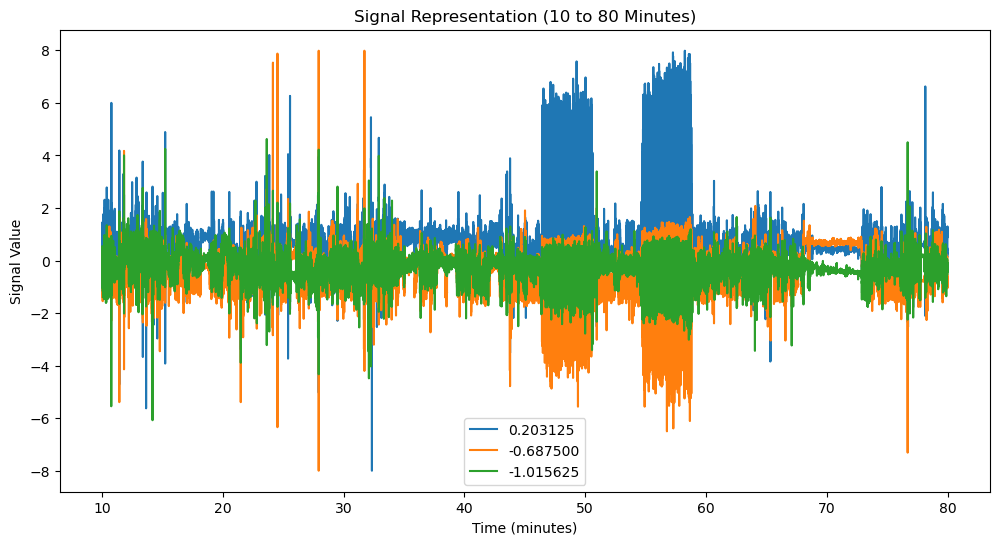

In [8]:
# Filter data to keep only rows where time is between 10 and 80 minutes
filtered_data = data[(data['relative_time_minutes'] >= 10) & (data['relative_time_minutes'] <= 80)]


# Plot the filtered signal
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data['relative_time_minutes'], filtered_data[signal], label=signal)

plt.title("Signal Representation (10 to 80 Minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

In [9]:
#2. Apply a Low-Pass Filter

In [10]:
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


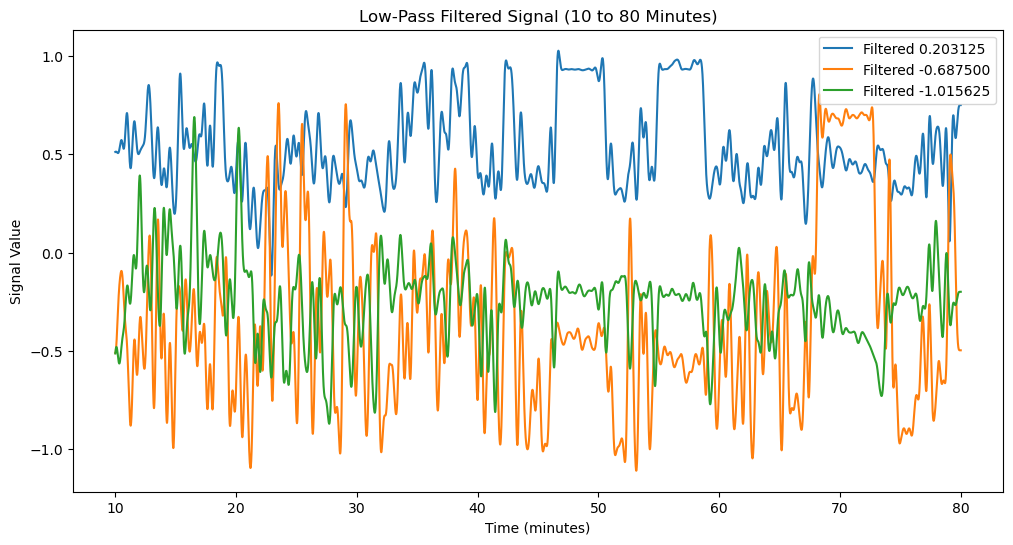

In [11]:
# Define sampling frequency (fs) and cutoff frequency
fs = 1 / (sampling_interval / 60)  # Sampling frequency in Hz (based on time in minutes)
cutoff = 2  # Low-pass filter cutoff frequency in Hz

# Apply the filter to each signal column
filtered_signals = {}
for signal in signal_columns:
    filtered_signals[signal] = lowpass_filter(filtered_data[signal], cutoff, fs)

# Convert filtered signals back to a DataFrame for easy plotting
filtered_data_df = pd.DataFrame(filtered_signals)
filtered_data_df['relative_time_minutes'] = filtered_data['relative_time_minutes'].values

# Plot the low-pass filtered signals
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal], label=f"Filtered {signal}")

plt.title("Low-Pass Filtered Signal (10 to 80 Minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

In [12]:
#[COM] Utilisation Pratique

Nombre total de pics détectés : 17
Intervalle moyen entre les pics : 4.12 minutes
Cadence moyenne : 0.79 pas par minute


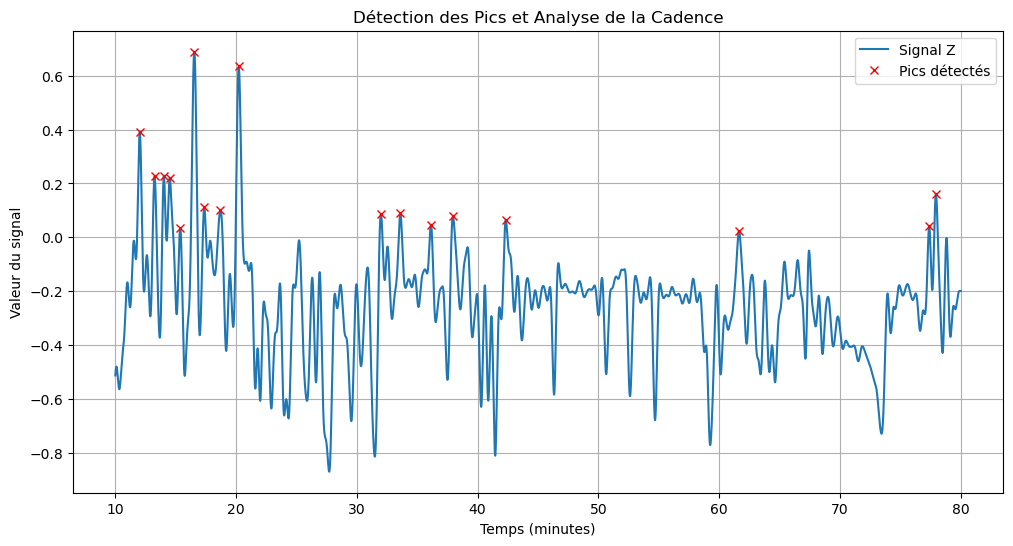

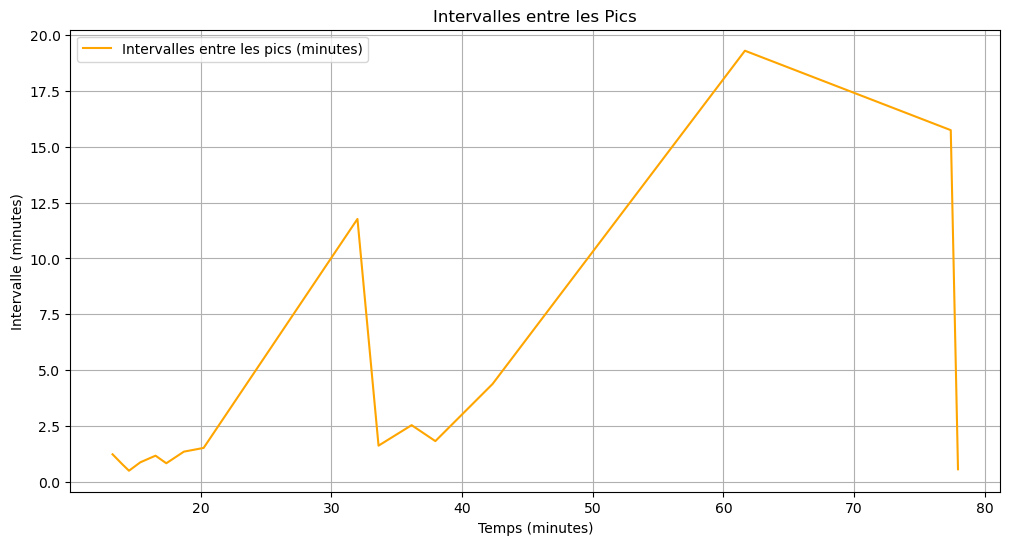

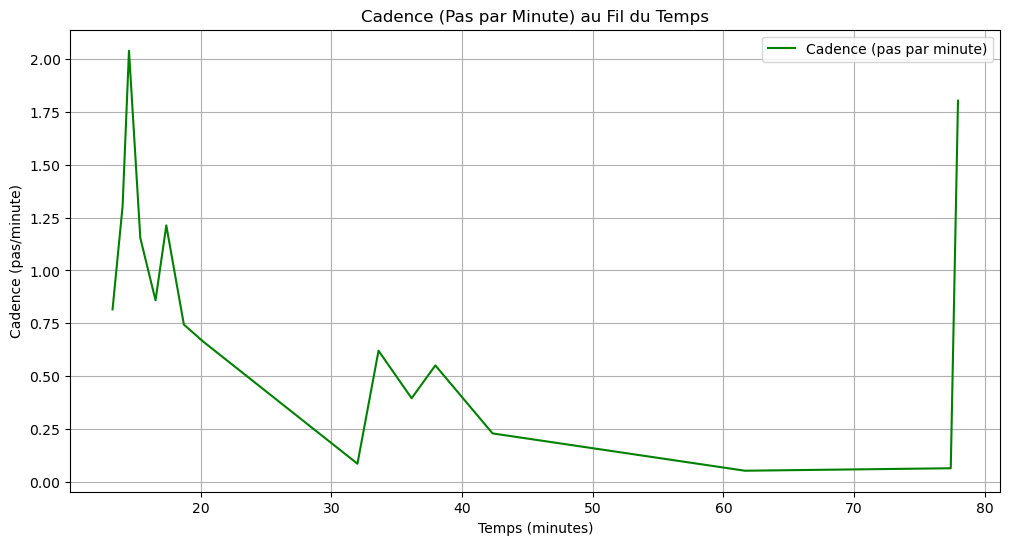

In [13]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Sélectionnez l'axe pertinent (par exemple, axe Z)
signal_column = signal_columns[2]  # Supposons que l'axe Z est la troisième colonne

# Détectez les pics dans le signal filtré
peaks, _ = find_peaks(filtered_data_df[signal_column], height=0)  # Ajustez 'height' si nécessaire

# Calculez les temps associés aux pics détectés
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Calculez les intervalles entre les pics (en minutes)
intervals = peak_times.diff().dropna()

# Convertissez les intervalles en cadence (pas par minute)
cadence = 1 / intervals  # En pas par minute

# Affichez les statistiques
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne : {cadence.mean():.2f} pas par minute")

# Visualisez le signal et les pics détectés
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal_column], label="Signal Z")
plt.plot(peak_times, filtered_data_df[signal_column].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des Pics et Analyse de la Cadence")
plt.xlabel("Temps (minutes)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez les intervalles entre les pics
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], intervals, label="Intervalles entre les pics (minutes)", color='orange')
plt.title("Intervalles entre les Pics")
plt.xlabel("Temps (minutes)")
plt.ylabel("Intervalle (minutes)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez la cadence
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], cadence, label="Cadence (pas par minute)", color='green')
plt.title("Cadence (Pas par Minute) au Fil du Temps")
plt.xlabel("Temps (minutes)")
plt.ylabel("Cadence (pas/minute)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#Analyse des Graphiques